- 이전 섹션에서는 nonlinear data를 linear model로 classify 해봄
- 당연히 잘 안된다
    - 물론 quadratic을 input으로 넣으면 되긴 하지만 그건 어디까지나 이게 quadratic이라고 알고 있으니까 된거
- 이번엔 nonlinear model로 해본다

type(X) = <class 'numpy.ndarray'>
X.shape = (2000, 2)
y.shape = (2000,)


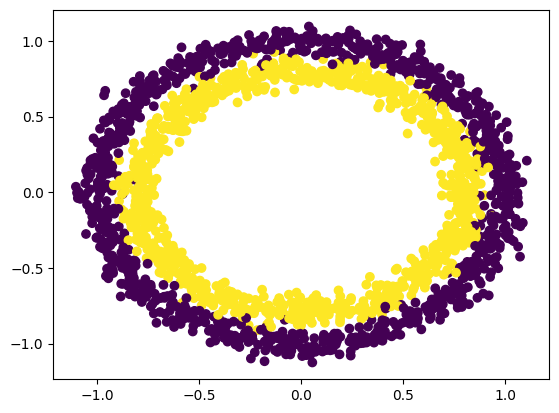

In [6]:
# 1. import 및 데이터 생성 (앞과 동일)

import matplotlib.pyplot
import numpy
import torch
import sklearn.datasets
import sklearn.model_selection

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 2000

# make_circles는 두 개의 원으로 구성된 데이터를 생성하는 함수
X,y = sklearn.datasets.make_circles(n, noise = 0.05)
X = X.astype(numpy.float32)
y = y.astype(numpy.float32)

print(f'type(X) = {type(X)}')
print(f'X.shape = {X.shape}') # 점의 좌표 
print(f'y.shape = {y.shape}') # 각 점의 class (0 or 1)

# visualize
matplotlib.pyplot.scatter(X[:,0], X[:,1], c=y) # c가 0/1의 array이면 색깔이 다르게 지정되는게 편리하다
matplotlib.pyplot.show()

# ndarray -> Tensor + train-test split
X = torch.from_numpy(X)
y = torch.from_numpy(y).unsqueeze(1)  # y.shape = (n,) -> (n,1)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [7]:
# Function은 모두 똑같이 사용한다

# define metric
def metric_accuracy(y_true, y_pred):
    num_correct = torch.eq(y_true, y_pred).sum().item() # sum()은 0차원의 tensor를 반환하므로 item()을 통해 scalar로 변환
    accuracy = num_correct / len(y_true)
    return accuracy

# define training function
def train_bcelogit(X_train, y_train, X_test, y_test, epoch_cnt, model, optimizer):
    # loss function은 이것으로 고정
    loss_bcelogit = torch.nn.BCEWithLogitsLoss()

    X_train_prev_device = X_train.device
    y_train_prev_device = y_train.device
    X_test_prev_device = X_test.device
    y_test_prev_device = y_test.device

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model.train() # train mode로 전환
    batch_size = 32
    for e in range(epoch_cnt):
        # batch size를 32로 설정한다
        for b in range(0, len(X_train), batch_size):
            X_batch = X_train[b:b+batch_size]
            y_batch = y_train[b:b+batch_size]

            # 1. forward pass 실행
            y_logit = model(X_batch) 
            
            # 2. loss 계산
            # torch.nn.BCEWithLogitsLoss()는 sigmoid + binary cross entropy를 한번에 계산해 주므로 y_logit을 그대로 넣어준다
            loss = loss_bcelogit(y_logit, y_batch)

            # 3. gradient 초기화. 이걸 안하면 gradient가 누적된다고 한다
            optimizer.zero_grad()
            # 4. 각 요소의 gradient contribution을 계산한다 
            loss.backward() 
            # 5. gradient descent를 실제 실행한다
            optimizer.step() 

        if e % 10 == 0:
            model.eval() # model을 evaluation mode로 설정한다
            with torch.inference_mode():
                y_pred_test_logit = model(X_test)
                test_loss = loss_bcelogit(y_pred_test_logit, y_test)

                y_pred_test = torch.round(torch.sigmoid(y_pred_test_logit))
                test_acc = metric_accuracy(y_test, y_pred_test)

                print(f'Epoch {e}: test_loss: {test_loss:.2f}    test_acc: {test_acc:.2f}')

            model.train() # model을 training mode로 원상 복구
    
    X_train = X_train.to(X_train_prev_device)
    y_train = y_train.to(y_train_prev_device)
    X_test = X_test.to(X_test_prev_device)
    y_test = y_test.to(y_test_prev_device)

# decision boundary function

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor, resolution = 1000):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # linspace(start, stop, num) -> Return evenly spaced numbers over a specified interval.
    # meshgrid(x, y) -> Return coordinate matrices from coordinate vectors.
    xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, resolution + 1), numpy.linspace(y_min, y_max, resolution + 1))

    # Make features
    # ravel() -> Return a contiguous flattened array.
    X_to_pred_on = torch.from_numpy(numpy.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    matplotlib.pyplot.contourf(xx, yy, y_pred, cmap=matplotlib.pyplot.cm.RdYlBu, alpha=0.7)
    matplotlib.pyplot.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=matplotlib.pyplot.cm.RdYlBu, alpha=0.5)
    matplotlib.pyplot.xlim(xx.min(), xx.max())
    matplotlib.pyplot.ylim(yy.min(), yy.max())

In [8]:
# Nonlinear Model

class CircleModelNonlinear(torch.nn.Module):
    def __init__(self, feature_cnt):
        super().__init__()
        self.seq_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=feature_cnt),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=feature_cnt, out_features=1)
        )
    
    def forward(self, X):
        return self.seq_layer(X)

Epoch 0: test_loss: 0.69    test_acc: 0.54
Epoch 10: test_loss: 0.57    test_acc: 0.67
Epoch 20: test_loss: 0.56    test_acc: 0.68
Epoch 30: test_loss: 0.57    test_acc: 0.67
Epoch 40: test_loss: 0.57    test_acc: 0.67
Epoch 50: test_loss: 0.56    test_acc: 0.68
Epoch 60: test_loss: 0.56    test_acc: 0.68
Epoch 70: test_loss: 0.56    test_acc: 0.68
Epoch 80: test_loss: 0.57    test_acc: 0.68
Epoch 90: test_loss: 0.57    test_acc: 0.67


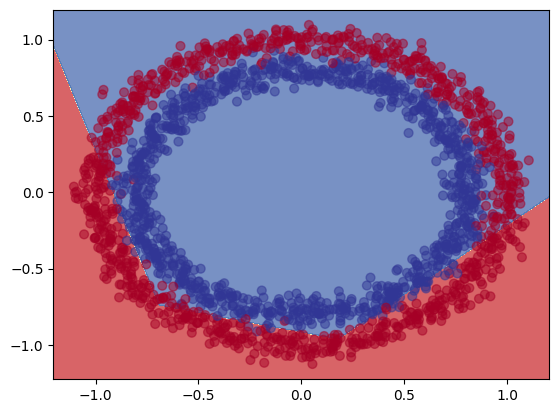

In [14]:
# create model instance
# 일부러 각지라고 feature를 적게 잡음. 다시 돌리면 경우에 따라 잘 안나올수도 있다
model_4 = CircleModelNonlinear(4).to(device) 

# define optimizer
optimizer_4 = torch.optim.Adam(params=model_4.parameters(), lr=0.1)

# loss function : torch.nn.BCEWithLogitsLoss() 으로 고정

# train
train_bcelogit(X_train, y_train, X_test, y_test, 100, model_4, optimizer_4)
plot_decision_boundary(model_4, X, y)

Epoch 0: test_loss: 0.64    test_acc: 0.61
Epoch 10: test_loss: 0.18    test_acc: 0.94
Epoch 20: test_loss: 0.21    test_acc: 0.91
Epoch 30: test_loss: 0.23    test_acc: 0.91
Epoch 40: test_loss: 0.25    test_acc: 0.90
Epoch 50: test_loss: 0.26    test_acc: 0.90
Epoch 60: test_loss: 0.23    test_acc: 0.92
Epoch 70: test_loss: 0.23    test_acc: 0.92
Epoch 80: test_loss: 0.23    test_acc: 0.92
Epoch 90: test_loss: 0.23    test_acc: 0.92


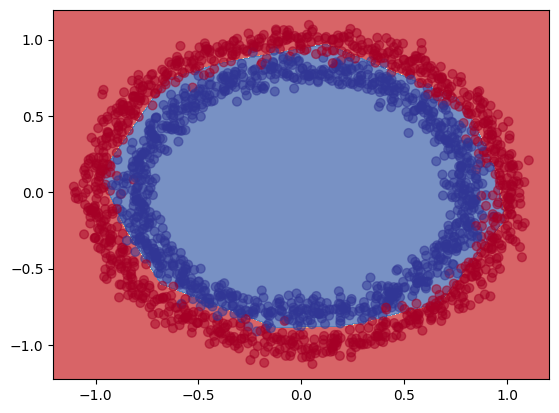

In [10]:
# feature 수를 늘리면 좀 더 정확하게 분류되는걸 볼 수 있다

# create model instance
model_20 = CircleModelNonlinear(20).to(device)

# define optimizer
optimizer_20 = torch.optim.Adam(params=model_20.parameters(), lr=0.1)

# loss function : torch.nn.BCEWithLogitsLoss() 으로 고정

# train
train_bcelogit(X_train, y_train, X_test, y_test, 100, model_20, optimizer_20)
plot_decision_boundary(model_20, X, y)